<a href="https://colab.research.google.com/github/mlvlab/data303/blob/main/Image_Generation_by_Gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Density Estimation
======

* Gaussian

In [1]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np

use_gpu = False

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We do not center them at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
batch_size = len(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
for X, y in train_dataloader:
    break;
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

In [3]:
# For visualization
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
def to_img(x): # Project pixel values on the unit interval [0,1] 
    x = x.clamp(0, 1)
    return x

def imshow_tensor(img, cmap='gray'):
    img = to_img(img)
    if img.get_device() >=0:
        # if the img tensor is on GPU
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap=cmap)
    
def imshow_cov_tensor(S, cmap='gray'):
    imshow_tensor(S[None, ...], cmap=cmap)

Compute Mean and Covariance Matrix without iterations 
=========================

In [4]:
train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
batch_size = len(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
for X, y in train_dataloader:
    break;

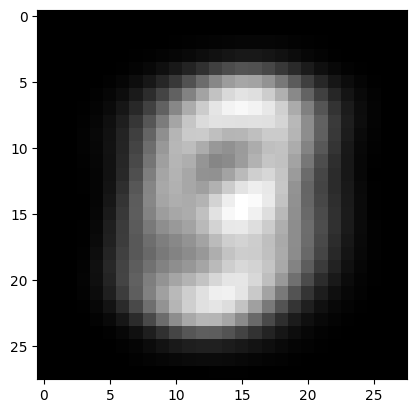

In [5]:
# Compute Mean of training data
mu = torch.mean(X,0)
imshow_tensor(mu)

In [6]:
# Compute covariance matrix of training data
S = torch.cov(X.reshape(batch_size,-1).transpose(1,0))

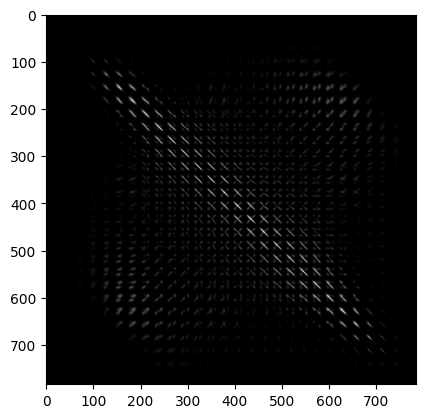

In [7]:
imshow_cov_tensor(S)

Generate samples from learned Gaussian
==========================
* $\mu$ is the sample mean 
* $S$ is the sample covariance matrix 
* We use $\tilde{S} + \alpha I$ to have a positive definite covariance matrix, where $\alpha>0$ is small

In [8]:
# Add small identify to avoid rank-deficient covariance matrix (0 variance... at some pixels)
alpha = 0.0001
Saug = S+alpha*torch.eye(S.shape[0]) # Augment the Covariance Matrix
mu_vec= mu.view(-1)
mvn = torch.distributions.multivariate_normal.MultivariateNormal(mu_vec, Saug)

In [9]:
x_gen = mvn.sample().reshape(1,28,-1)

In [10]:
n_samples = 50
width = 28
height = 28

X_gen = torch.zeros(n_samples, width, height)
for i in range(50):
    X_gen[i] = mvn.sample().reshape(28,-1)

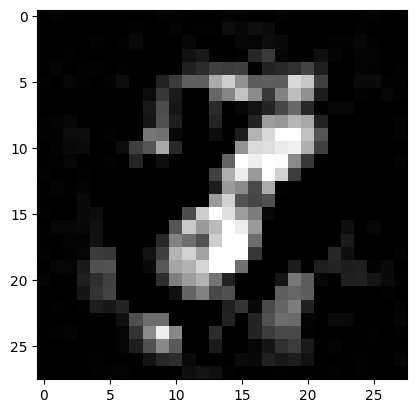

In [11]:
idx = 0
imshow_tensor(X_gen[None, idx, ...]) # visualize the first image

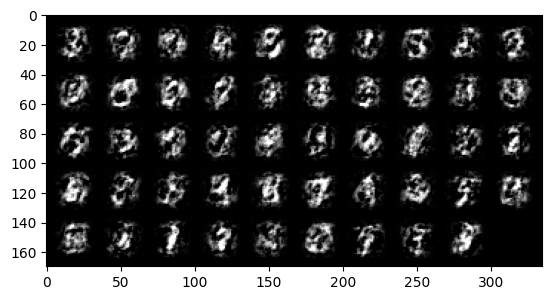

In [12]:
# Visualize all the generated images
images = X_gen.cpu()[:,None,...]
images = to_img(images)
np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
plt.show()